### **INDEX**
1. Setup notebook
2. Data cleaning
3. Data prep for analysis
4. Regression analysis
5. Bonus: performance improvement
6. Research findings

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

### **1. SETUP NOTEBOOK**

In [5]:
# import libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os
from pathlib import Path
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
# activate inline matplotlib visuals 
%matplotlib inline

In [7]:
# get the current working directory as a Path object
path = Path.cwd()

# update the path to parent folder
parent_path = path.parent

In [8]:
# import lego data set
csv_file_path = parent_path / '2 Data' / 'Prepared data' / 'lego_analysis.csv'

# import data as datafram
df_lego_analysis = pd.read_csv(csv_file_path)

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

### **2. DATA CLEANING**

In [11]:
# check shape
df_lego_analysis.shape

(7815, 33)

In [12]:
# check columns
df_lego_analysis.columns

Index(['Unnamed: 0', 'set_number', 'setID', 'name', 'year', 'theme',
       'themeGroup', 'subtheme', 'category', 'pieces', 'minifigs', 'ownedBy',
       'wantedBy', 'rating', 'reviewCount', 'packagingType', 'availability',
       'instructionsCount', 'minAge', 'US_retailPrice', 'UK_retailPrice',
       'CA_retailPrice', 'DE_retailPrice', 'PL_retailPrice', 'status',
       'year_time', 'year_period', 'set_num', 'theme_id', 'num_parts',
       'num_colors', 'num_materials', 'sum_spares'],
      dtype='object')

**Generating hypotheses to test and prepare data for**

1. LEGO themes become more colorful (y) over time (X).
2. Franchise LEGO sets (X) have more minifigs (y) than non-franchise LEGO sets (X).

In [14]:
# normalizing retail prices for fair data interpretation
# get exchange rates in USD
exchange_rates = {
    'US_retailPrice': 1,  # USD (base currency)
    'UK_retailPrice': 1.36,  # Assuming 1 GBP = 1.36 USD
    'CA_retailPrice': 0.79,  # Assuming 1 CAD = 0.79 USD
    'DE_retailPrice': 1.18,  # Assuming 1 EUR = 1.18 USD
    'PL_retailPrice': 0.26   # Assuming 1 PLN = 0.26 USD
}

#normalize each market retail price by exchange rates + handling NaNs as 0
df_lego_analysis['US_normalized'] = df_lego_analysis['US_retailPrice'].fillna(0) * exchange_rates['US_retailPrice']
df_lego_analysis['UK_normalized'] = df_lego_analysis['UK_retailPrice'].fillna(0) * exchange_rates['UK_retailPrice']
df_lego_analysis['CA_normalized'] = df_lego_analysis['CA_retailPrice'].fillna(0) * exchange_rates['CA_retailPrice']
df_lego_analysis['DE_normalized'] = df_lego_analysis['DE_retailPrice'].fillna(0) * exchange_rates['DE_retailPrice']
df_lego_analysis['PL_normalized'] = df_lego_analysis['PL_retailPrice'].fillna(0) * exchange_rates['PL_retailPrice']

#create new column where average retail price across the 5 markets is calculated in dollars
df_lego_analysis['avg_rp'] = df_lego_analysis[['US_normalized', 'UK_normalized', 'CA_normalized', 'DE_normalized', 'PL_normalized']].mean(axis=1).round(2)

In [15]:
# subsetting selected columns for regression analysis
df_reg = df_lego_analysis[['set_num', 'theme', 'pieces', 'minifigs', 'ownedBy', 'wantedBy', 'rating', 'reviewCount', 'minAge', 'US_normalized', 'UK_normalized', 'CA_normalized', 'DE_normalized', 'PL_normalized', 'year_period', 'num_parts', 'num_colors', 'num_materials', 'sum_spares']]

In [16]:
df_reg.shape[0]

7815

In [17]:
df_reg.isnull().sum()

set_num             0
theme               0
pieces            122
minifigs         2334
ownedBy             8
wantedBy            0
rating              0
reviewCount         0
minAge           2190
US_normalized       0
UK_normalized       0
CA_normalized       0
DE_normalized       0
PL_normalized       0
year_period         0
num_parts         212
num_colors        167
num_materials     167
sum_spares        167
dtype: int64

In [18]:
# drop rows with NaN values in num_colors 
df_reg = df_reg.dropna(subset=['num_colors'])

In [19]:
#check rows only
df_reg.shape[0]

7648

In [20]:
# subset franchise and non-franchise LEGO sets
# define franchise collection
franchise_themes = ['Avatar', 'Cars', 'Pirates of the Caribbean', 'The Lone Ranger', 'Toy Story', 
                    'Frozen', 'Trolls World Tour', 'The Simpsons', 'Marvel Super Heroes', 'Spider-Man', 
                    'Star Wars', 'Indiana Jones', 'Batman', 'DC Comics Super Heroes', 
                    'DC Super Hero Girls', 'Harry Potter', 'The LEGO Batman Movie', 'The LEGO Movie', 
                    'The LEGO Movie 2', 'The LEGO Ninjago Movie', 'The Lord of the Rings', 'The Hobbit', 
                    'Ben 10: Alien Force', 'Scooby-Doo', 'Jurassic World', 'Minions: The Rise of Gru', 
                    'The Angry Birds Movie', 'Ghostbusters', 'Teenage Mutant Ninja Turtles', 
                    'Prince of Persia', 'Stranger Things', "Gabby's Dollhouse", 'The Powerpuff Girls', 
                    'Mickey Mouse', 'Super Mario', 'Minecraft', 'Overwatch', 'SpongeBob SquarePants', 'Disney', 
                   'BrickHeadz', 'Brick Sketches', 'Speed Champions', 'Unikitty' ]

# create franchise flag
df_reg.loc[:, 'franchise_flag'] = df_reg['theme'].apply(
    lambda theme: 'franchise' if theme in franchise_themes else 'non-franchise')

In [21]:
# create subset for franchise sets
df_fran = df_reg.loc[df_reg['franchise_flag'] == 'franchise']

In [22]:
df_fran.isnull().sum()

set_num             0
theme               0
pieces             61
minifigs          400
ownedBy             5
wantedBy            0
rating              0
reviewCount         0
minAge            478
US_normalized       0
UK_normalized       0
CA_normalized       0
DE_normalized       0
PL_normalized       0
year_period         0
num_parts           0
num_colors          0
num_materials       0
sum_spares          0
franchise_flag      0
dtype: int64

In [23]:
# drop rows with NaN values in pieces
df_fran = df_fran.dropna(subset=['pieces'])

In [24]:
# drop rows with NaN values in pieces
df_fran = df_fran.dropna(subset=['minifigs'])

In [25]:
# create set for non-franchise sets
df_non_fran = df_reg.loc[df_reg['franchise_flag'] == 'non-franchise']

In [26]:
df_non_fran.isnull().sum()

set_num              0
theme                0
pieces               3
minifigs          1836
ownedBy              2
wantedBy             0
rating               0
reviewCount          0
minAge            1672
US_normalized        0
UK_normalized        0
CA_normalized        0
DE_normalized        0
PL_normalized        0
year_period          0
num_parts           66
num_colors           0
num_materials        0
sum_spares           0
franchise_flag       0
dtype: int64

In [27]:
# drop rows with NaN values in pieces
df_non_fran = df_non_fran.dropna(subset=['pieces'])

In [28]:
# drop rows with NaN values in pieces
df_non_fran = df_non_fran.dropna(subset=['minifigs'])

In [29]:
df_reg['num_colors'].describe()

count    7648.000000
mean       13.468619
std         8.296853
min         1.000000
25%         7.000000
50%        12.000000
75%        18.000000
max        53.000000
Name: num_colors, dtype: float64

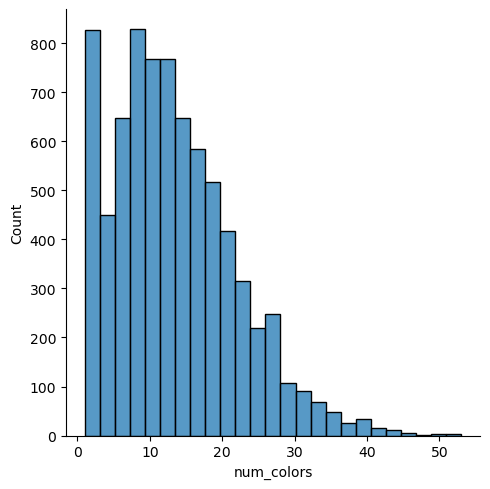

In [30]:
# extreme values check for dependent variables (y)
sns.displot(df_reg['num_colors'], bins=25) # Shows extreme values

> num_colors has no extreme values

In [32]:
df_fran['minifigs'].describe()

count    1600.000000
mean        3.566875
std         2.696771
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        28.000000
Name: minifigs, dtype: float64

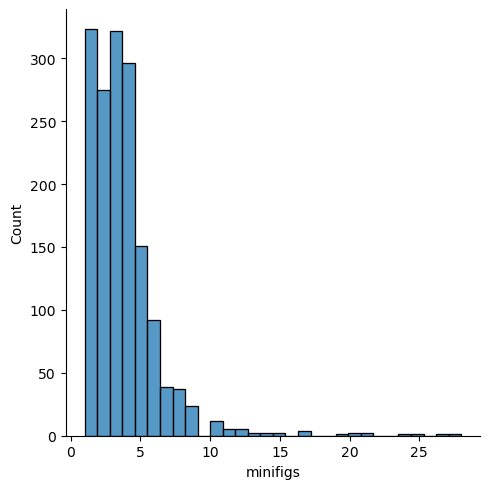

In [33]:
sns.displot(df_fran['minifigs'], bins=30) 

In [34]:
df_non_fran['minifigs'].describe()

count    3772.000000
mean        2.573701
std         2.595741
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        32.000000
Name: minifigs, dtype: float64

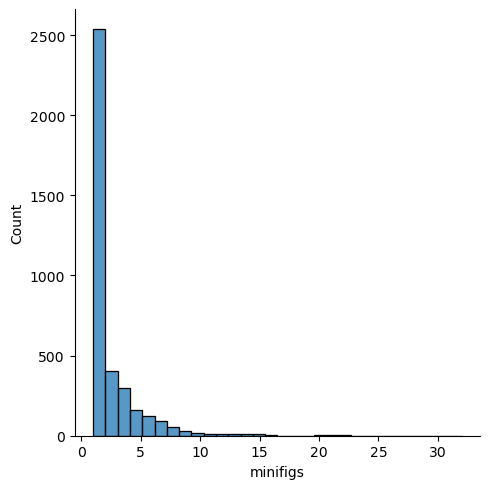

In [35]:
sns.displot(df_non_fran['minifigs'], bins=30) 

> **Observation**: 
> - minifigs show an extreme value of almost 3000 non-franchise LEGO sets with 1 minifig, however, this could be due to the minifigs that are being sold in single bags. 
> - comparing the minifigs per franchise / non-franchise sets, it's seems not that different at all.

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

### **3. DATA PREP FOR REGRESSION ANALYSIS**

**1. LEGO themes become more colorful (y) over time (X)**

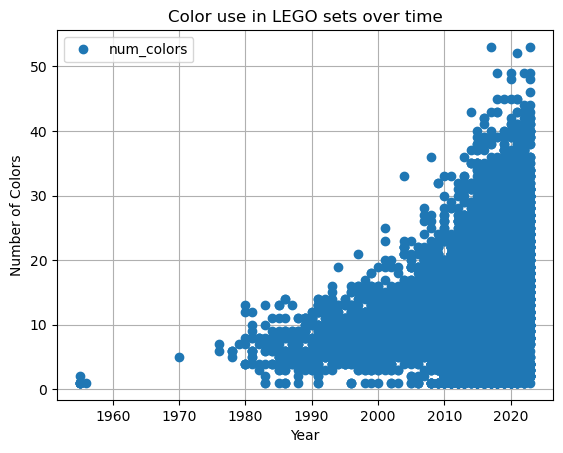

In [40]:
# plot the variables in a scatterplot

df_reg.plot(x = 'year_period', y='num_colors',style='o') 
plt.title('Color use in LEGO sets over time')  
plt.xlabel('Year')  
plt.ylabel('Number of Colors')  
plt.grid(True)
plt.show()

In [41]:
# reshape the variables into NumPy arrays and put them into separate objects
X = df_reg['year_period'].values.reshape(-1,1)
y = df_reg['num_colors'].values.reshape(-1,1)

In [42]:
# split data into a training set and a test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

**2. Franchise LEGO sets (X) have more minifigs (y) than non-franchise LEGO sets (X).**

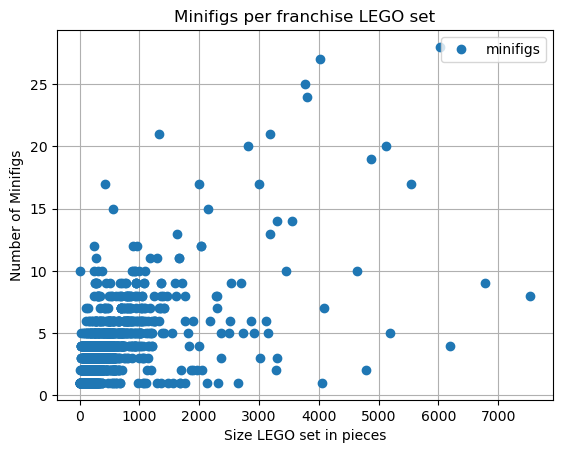

In [45]:
# plot the variables in a scatterplot

df_fran.plot(x ='pieces', y='minifigs',style='o') 
plt.title('Minifigs per franchise LEGO set')  
plt.xlabel('Size LEGO set in pieces')  
plt.ylabel('Number of Minifigs')  
plt.grid(True)
plt.show()

In [46]:
# reshape the variables into NumPy arrays and put them into separate objects
X_mf = df_fran['pieces'].values.reshape(-1,1)
y_mf = df_fran['minifigs'].values.reshape(-1,1)

In [47]:
# split data into a training set and a test set.
X_mf_train, X_mf_test, y_mf_train, y_mf_test = train_test_split(X_mf, y_mf, test_size=0.3, random_state=0)

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

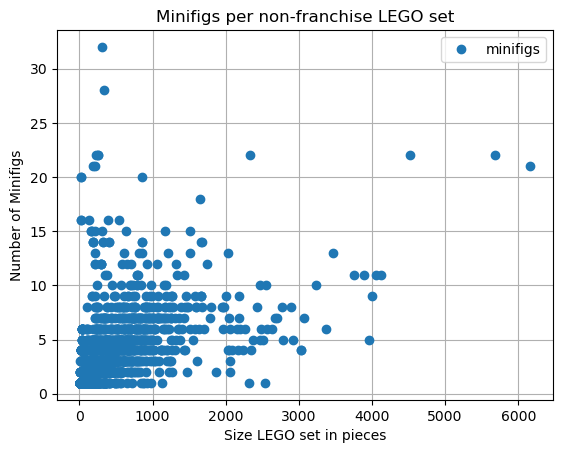

In [49]:
# plot the variables in a scatterplot

df_non_fran.plot(x ='pieces', y='minifigs',style='o') 
plt.title('Minifigs per non-franchise LEGO set')  
plt.xlabel('Size LEGO set in pieces')  
plt.ylabel('Number of Minifigs')  
plt.grid(True)
plt.show()

In [50]:
# reshape the variables into NumPy arrays and put them into separate objects
X_mf_non = df_non_fran['pieces'].values.reshape(-1,1)
y_mf_non = df_non_fran['minifigs'].values.reshape(-1,1)

In [51]:
# split data into a training set and a test set.
X_mf_non_train, X_mf_non_test, y_mf_non_train, y_mf_non_test = train_test_split(X_mf_non, y_mf_non, test_size=0.3, random_state=0)

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

### **4. REGRESSION ANALYSIS**

**1. LEGO themes become more colorful (y) over time (X)**

In [55]:
# create a regression object
regression = LinearRegression()

In [56]:
# fit the regression object onto the training set
regression.fit(X_train, y_train)

LinearRegression()

In [57]:
# predict the test values of y using X
y_predicted = regression.predict(X_test)

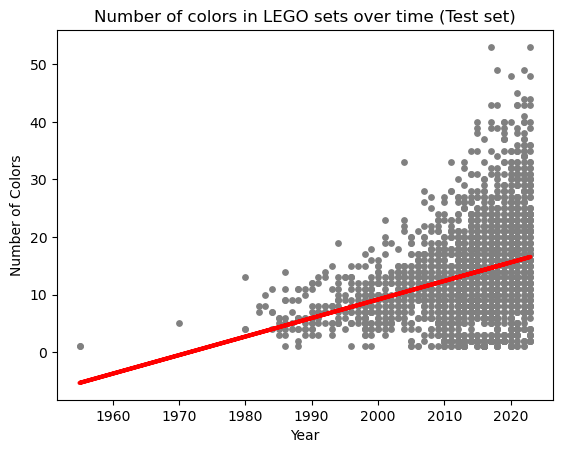

In [58]:
# create a plot that shows the regression line from the model on the test set
plot_test = plt
plot_test.scatter(X_test, y_test, color='gray', s = 15)
plot_test.plot(X_test, y_predicted, color='red', linewidth =3)
plot_test.title('Number of colors in LEGO sets over time (Test set)')
plot_test.xlabel('Year')
plot_test.ylabel('Number of Colors')
plot_test.show()

> **Observation**: The line does not fit the data points. There's a both a density and a spread to be read, especially from 2010 on.

In [60]:
# create objects that contain the model summary statistics
rmse = mean_squared_error(y_test, y_predicted) 
r2 = r2_score(y_test, y_predicted) 

In [61]:
# print the model summary statistics
print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[0.32176983]]
Mean squared error:  65.3336761842768
R2 score:  0.11642013760836478


> **Observation**:
> The model did not perform well for this hypothesis.  
> - The mean squared error is high, meaning the regression line is far off of the data points.
> - With the r being 0.11, it indicates only a weak relationship and suggest no consistent increase of color use in lego sets over time.
> - In other words: Even though the number of colors in a LEGO sets do increase over time, their increase is not based on time. Perhaps theme? 

In [63]:
# create a dataframe comparing the actual and predicted values of y.
data = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_predicted.flatten()})
data.head(30)

,Actual,Predicted
0,16.0,13.018214
1,12.0,13.339983
2,23.0,14.627063
3,22.0,16.235912
4,19.0,13.018214
5,6.0,7.226357
6,11.0,13.339983
7,20.0,15.592372
8,5.0,13.339983
9,13.0,11.409364


> **Observation**: The distance between actual and predicted values is both inconsisent and inaccurate. 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

**2. Franchise LEGO sets (X) have more minifigs (y) than non-franchise LEGO sets (X).**

In [67]:
# fit the regression object onto the training set 
regression.fit(X_mf_train, y_mf_train)

LinearRegression()

In [68]:
# predict the test values of y using X
y_mf_predicted = regression.predict(X_mf_test)

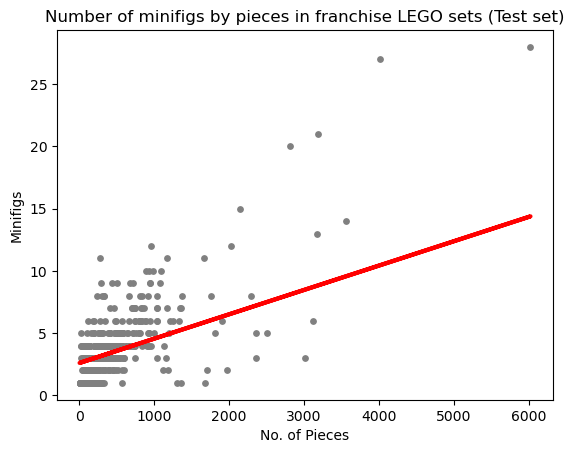

In [69]:
# create a plot that shows the regression line from the model on the test set
plot_test_mf = plt
plot_test_mf.scatter(X_mf_test, y_mf_test, color='gray', s = 15)
plot_test_mf.plot(X_mf_test, y_mf_predicted, color='red', linewidth =3)
plot_test_mf.title('Number of minifigs by pieces in franchise LEGO sets (Test set)')
plot_test_mf.xlabel('No. of Pieces')
plot_test_mf.ylabel('Minifigs')
plot_test_mf.show()

> **Observation**: The line does not fit the data points. The main point is the spread of datapoints across in set size <1000 and ~5 minifigs. Solving for the outliers won't improve the outcome and insights from linear regression. 

In [71]:
# create objects that contain the model summary statistics
rmse_mf = mean_squared_error(y_mf_test, y_mf_predicted) 
r2_mf = r2_score(y_mf_test, y_mf_predicted) 

In [72]:
# print the model summary statistics
print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse_mf)
print('R2 score: ', r2_mf)

Slope: [[0.00195852]]
Mean squared error:  5.22016972801811
R2 score:  0.4124451611548524


In [73]:
df_fran['minifigs'].describe()

count    1600.000000
mean        3.566875
std         2.696771
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        28.000000
Name: minifigs, dtype: float64

> **Observation**:
> The model did not perform well for this hypothesis.  
> - The mean squared error is 6, which in this context is high, considering the range of minifigs is 1-28. Meaning the regression line is  off by 20% for most data points (6/28 is 20%)
> - With the r being 0.37, it could be considered a moderate relationship, however, it's not sufficient. 

In [75]:
# create a dataframe comparing the actual and predicted values of y.
data_mf = pd.DataFrame({'Actual': y_mf_test.flatten(), 'Predicted': y_mf_predicted.flatten()})
data_mf.head(30)

,Actual,Predicted
0,1.0,2.661509
1,2.0,2.984666
2,3.0,3.399873
3,5.0,3.397915
4,4.0,2.645841
5,3.0,2.692846
6,3.0,3.088468
7,3.0,2.632132
8,1.0,3.088468
9,1.0,3.243191


> **Observation**: The distance between actual and predicted values is both inconsisent and inaccurate. 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [78]:
# fit the regression object onto the training set 
regression.fit(X_mf_non_train, y_mf_non_train)

LinearRegression()

In [79]:
# predict the test values of y using X
y_mf_non_predicted = regression.predict(X_mf_non_test)

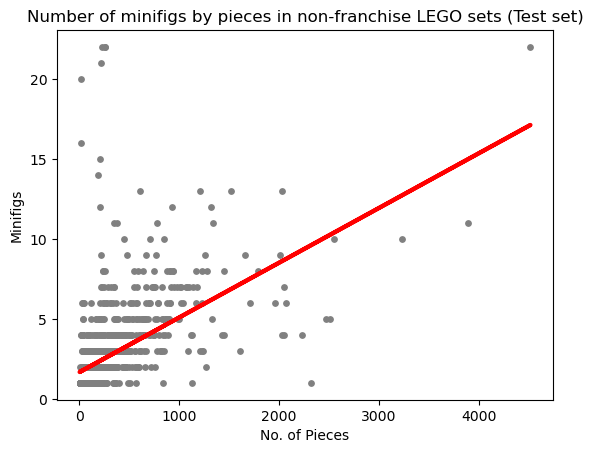

In [80]:
# create a plot that shows the regression line from the model on the test set
plot_test_mf_non = plt
plot_test_mf_non.scatter(X_mf_non_test, y_mf_non_test, color='gray', s = 15)
plot_test_mf_non.plot(X_mf_non_test, y_mf_non_predicted, color='red', linewidth =3)
plot_test_mf_non.title('Number of minifigs by pieces in non-franchise LEGO sets (Test set)')
plot_test_mf_non.xlabel('No. of Pieces')
plot_test_mf_non.ylabel('Minifigs')
plot_test_mf_non.show()

In [81]:
# create objects that contain the model summary statistics
rmse_mf_non = mean_squared_error(y_mf_non_test, y_mf_non_predicted) 
r2_mf_non = r2_score(y_mf_non_test, y_mf_non_predicted) 

In [82]:
# print the model summary statistics
print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse_mf_non)
print('R2 score: ', r2_mf_non)

Slope: [[0.0034239]]
Mean squared error:  4.495201751866577
R2 score:  0.33026158040872244


In [83]:
# create a dataframe comparing the actual and predicted values of y.
data_mf_non = pd.DataFrame({'Actual': y_mf_non_test.flatten(), 'Predicted': y_mf_non_predicted.flatten()})
data_mf_non.head(30)

,Actual,Predicted
0,4.0,4.544269
1,1.0,2.596070
2,1.0,1.890747
3,1.0,1.798302
4,3.0,2.359821
5,4.0,3.181557
6,1.0,1.794878
7,1.0,1.685313
8,1.0,1.688737
9,6.0,2.729602


> **Observation**: The outcome for minifigs by non-franchise LEGO sets is not different than that of franchise LEGO sets. This analysis is not the right method to test this hypothesis. 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

## **5. PERFORMANCE IMPROVEMENT**

**1. LEGO themes become more colorful (y) over time (X)**

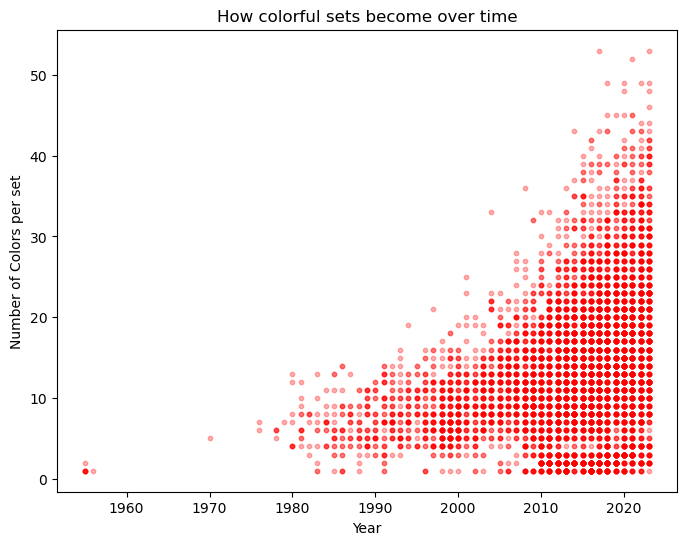

In [88]:
# optimize scatterplot for interpretion of density
plt.figure(figsize=(8, 6))
plt.scatter(df_reg['year_period'], df_reg['num_colors'], s=10, alpha=0.3, color='red') 
plt.xlabel('Year')
plt.ylabel('Number of Colors per set')
plt.title('How colorful sets become over time')
plt.show()

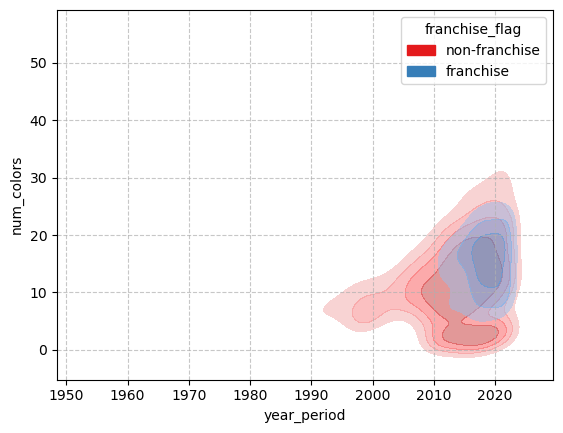

In [89]:
# optimize plot for interpreation by reducing clutter by a density treshhold of 30% + adding dimensions
sns.kdeplot(data=df_reg, x="year_period", y="num_colors", hue='franchise_flag', 
            levels=5, thresh=.3, fill=True, palette="Set1", alpha=.5)

plt.grid(True, linestyle='--', alpha=0.7) 

> **CONCLUSION**: Linear regression is not fit for this hypothesis as the relation is expontential. 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

## **6 RESEARCH FINDINGS**
1. LEGO themes become more colorful (y) over time (X). >> Even though the number of colors in a LEGO sets do increase over time, their increase is not based on time. I would want to explore the correlation with theme, based on the assumption that the growth overtime is based on new, more colorful themes were introduced over time.
2. Franchise LEGO sets (X) have more minifigs (y) than non-franchise LEGO sets (X). >> Test results are inconclusive. 